# Pandas II

## More indexing tricks

We'll start out with some data from Beer Advocate (see [Tom Augspurger](https://github.com/TomAugspurger/pydata-chi-h2t/blob/master/3-Indexing.ipynb) for some cool details on how he extracted this data)

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10

In [2]:
df = pd.read_csv('data/beer_subset.csv.gz', parse_dates=['time'], compression='gzip')
df.head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3.0,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,2009-10-05 21:32:13
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
4,5.8,398,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3.0,4.0,3.5,champ103,3.0,A: Pours a slightly hazy golden/orange color....,2009-10-05 21:33:14


### Boolean indexing

Like a where clause in SQL. 

The indexer (or boolean mask) should be 1-dimensional and the same length as the thing being indexed.

In [3]:
df['abv'] < 5

0      False
1      False
2       True
3      False
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: abv, dtype: bool

In [4]:
df.loc[df['abv'] < 5].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3.0,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,2009-10-05 21:32:13
7,4.8,1669,256,Great White,Witbier,4.5,4.5,4.5,4.5,n0rc41,4.5,"Ok, for starters great white I believe will b...",2009-10-05 21:34:29
21,4.6,401,118,Dark Island,Scottish Ale,4.0,4.0,3.5,4.0,abuliarose,4.0,"Poured into a snifter, revealing black opaque...",2009-10-05 21:47:36
22,4.9,5044,18968,Kipona Fest,Märzen / Oktoberfest,4.0,3.5,4.0,4.0,drcarver,4.0,A - a medium brown body with an off white hea...,2009-10-05 21:47:56
28,4.6,401,118,Dark Island,Scottish Ale,4.0,4.0,4.5,4.0,sisuspeed,4.0,The color of this beer fits the name well. Op...,2009-10-05 21:53:38


In [5]:
df.loc[((df['abv'] < 5) & (df['time'] > pd.Timestamp('2009-06'))) | 
       (df['review_overall'] >= 4.5)].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3.0,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,2009-10-05 21:32:13
6,6.2,53128,1114,Smokin' Amber Kegs Gone Wild,American Amber / Red Ale,3.5,4.0,4.5,4.0,Deuane,4.5,An American amber with the addition of smoked...,2009-10-05 21:34:24
7,4.8,1669,256,Great White,Witbier,4.5,4.5,4.5,4.5,n0rc41,4.5,"Ok, for starters great white I believe will b...",2009-10-05 21:34:29


Be careful with the order of operations...

In [6]:
2 > 1 & 0

True

Safest to use parentheses...

In [7]:
(2 > 1) & 0

0

Select just the rows where the `beer_style` contains `'IPA'`:

In [8]:
df.beer_style.str?

In [ ]:
df.beer_style.str.

In [9]:
df['beer_style'].str.contains('IPA')

0      False
1      False
2      False
3       True
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: beer_style, dtype: bool

In [10]:
df.loc[df['beer_style'].str.contains('IPA')].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
8,6.7,6549,140,Northern Hemisphere Harvest Wet Hop Ale,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31
16,8.0,36179,3818,Hoppe (Imperial Extra Pale Ale),American Double / Imperial IPA,4.0,3.0,4.0,3.5,nick76,3.0,"The aroma is papery with citrus, yeast, and s...",2009-10-05 21:43:23
23,6.5,44727,596,Portsmouth 5 C's IPA,American IPA,4.5,5.0,5.0,4.5,ALeF,5.0,As a devoted drinker of American and English ...,2009-10-05 21:48:46
26,5.9,37477,140,Sierra Nevada Anniversary Ale (2007-2009),American IPA,4.5,4.5,4.5,4.5,n0rc41,4.5,Poured a great dark color with great smell! t...,2009-10-05 21:51:33


Find the rows where the beer style is either `'American IPA'` or `'Pilsner'`:

In [11]:
df[(df['beer_style'] == 'American IPA') | (df['beer_style'] == 'Pilsner')].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
8,6.7,6549,140,Northern Hemisphere Harvest Wet Hop Ale,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31
23,6.5,44727,596,Portsmouth 5 C's IPA,American IPA,4.5,5.0,5.0,4.5,ALeF,5.0,As a devoted drinker of American and English ...,2009-10-05 21:48:46
26,5.9,37477,140,Sierra Nevada Anniversary Ale (2007-2009),American IPA,4.5,4.5,4.5,4.5,n0rc41,4.5,Poured a great dark color with great smell! t...,2009-10-05 21:51:33
32,7.5,6076,651,Flower Power India Pale Ale,American IPA,3.5,4.5,4.0,3.5,OnThenIn,4.0,Appearance: The beer pours a rather cloudy da...,2009-10-05 22:02:11
48,6.7,44749,140,Sierra Nevada Chico Estate Harvest Wet Hop Ale...,American IPA,4.5,3.5,4.0,4.5,mikey711,4.0,I love this concept. Way to go Sierra Nevada!...,2009-10-05 22:19:33


Or more succinctly:

In [12]:
df[df['beer_style'].isin(['American IPA', 'Pilsner'])].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
8,6.7,6549,140,Northern Hemisphere Harvest Wet Hop Ale,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31
23,6.5,44727,596,Portsmouth 5 C's IPA,American IPA,4.5,5.0,5.0,4.5,ALeF,5.0,As a devoted drinker of American and English ...,2009-10-05 21:48:46
26,5.9,37477,140,Sierra Nevada Anniversary Ale (2007-2009),American IPA,4.5,4.5,4.5,4.5,n0rc41,4.5,Poured a great dark color with great smell! t...,2009-10-05 21:51:33
32,7.5,6076,651,Flower Power India Pale Ale,American IPA,3.5,4.5,4.0,3.5,OnThenIn,4.0,Appearance: The beer pours a rather cloudy da...,2009-10-05 22:02:11
48,6.7,44749,140,Sierra Nevada Chico Estate Harvest Wet Hop Ale...,American IPA,4.5,3.5,4.0,4.5,mikey711,4.0,I love this concept. Way to go Sierra Nevada!...,2009-10-05 22:19:33


#### Mini Exercise

- Select the rows where the scores of the 5 review_cols ('review_appearance', 'review_aroma', 'review_overall', 'review_palate', 'review_taste') are all at least 4.0.

- _Hint_: Like NumPy arrays, DataFrames have an any and all methods that check whether it contains any or all True values. These methods also take an axis argument for the dimension to remove.
    - 0 or 'index' removes (or aggregates over) the vertical dimension
    - 1 or 'columns' removes (aggregates over) the horizontal dimension.

In [13]:
df.columns

Index(['abv', 'beer_id', 'brewer_id', 'beer_name', 'beer_style',
       'review_appearance', 'review_aroma', 'review_overall', 'review_palate',
       'profile_name', 'review_taste', 'text', 'time'],
      dtype='object')

In [14]:
review_cols = [c for c in df.columns if c[0:6] == 'review']
review_cols

['review_appearance',
 'review_aroma',
 'review_overall',
 'review_palate',
 'review_taste']

In [15]:
df[(df['review_appearance'] >= 4) &
   (df['review_aroma'] >= 4) &
   (df['review_overall'] >= 4) &
   (df['review_palate'] >= 4) &
   (df['review_taste'] >= 4)].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
7,4.8,1669,256,Great White,Witbier,4.5,4.5,4.5,4.5,n0rc41,4.5,"Ok, for starters great white I believe will b...",2009-10-05 21:34:29
8,6.7,6549,140,Northern Hemisphere Harvest Wet Hop Ale,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31


Or the short way:

In [16]:
df[(df[review_cols] >= 4).all(1)].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
7,4.8,1669,256,Great White,Witbier,4.5,4.5,4.5,4.5,n0rc41,4.5,"Ok, for starters great white I believe will b...",2009-10-05 21:34:29
8,6.7,6549,140,Northern Hemisphere Harvest Wet Hop Ale,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31


In [17]:
(df[review_cols] >= 4)

,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,True,True,True,True,True
1,True,True,True,True,True
2,True,False,False,False,False
3,True,True,True,True,True
4,True,False,True,False,False
...,...,...,...,...,...
994,True,True,False,True,True
995,True,False,True,True,True
996,False,True,False,False,True
997,True,False,False,False,True


In [18]:
(df[review_cols] >= 4).all(axis=1)

0       True
1       True
2      False
3       True
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
dtype: bool

In [19]:
df[(df[review_cols] >= 4).all(1)].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
7,4.8,1669,256,Great White,Witbier,4.5,4.5,4.5,4.5,n0rc41,4.5,"Ok, for starters great white I believe will b...",2009-10-05 21:34:29
8,6.7,6549,140,Northern Hemisphere Harvest Wet Hop Ale,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31


Now select rows where the _average_ of the 5 `review_cols` is at least 4.

In [20]:
df[review_cols].mean(axis=1)

0      4.3
1      4.2
2      3.3
3      4.0
4      3.5
      ... 
994    4.0
995    4.2
996    3.5
997    3.7
998    3.7
dtype: float64

In [21]:
df[df[review_cols].mean(axis=1) >= 4].head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,2009-10-05 21:31:48
1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,2009-10-05 21:32:09
3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
5,7.0,966,365,Pike Street XXXXX Stout,American Stout,4.0,4.0,3.5,4.0,sprucetip,4.5,"From notes. Pours black, thin mocha head fade...",2009-10-05 21:33:48
6,6.2,53128,1114,Smokin' Amber Kegs Gone Wild,American Amber / Red Ale,3.5,4.0,4.5,4.0,Deuane,4.5,An American amber with the addition of smoked...,2009-10-05 21:34:24


## Hierarchical Indexing

- One of the most powerful and most complicated features of pandas
- Let's you represent high-dimensional datasets in a table

In [22]:
reviews = df.set_index(['profile_name', 'beer_id', 'time'])
reviews.head()

,,,abv,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_taste,text
profile_name,beer_id,time,,,,,,,,,,
blaheath,2511,2009-10-05 21:31:48,7.0,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,4.5,Batch 8144\tPitch black in color with a 1/2 f...
GJ40,19736,2009-10-05 21:32:09,5.7,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,4.0,Sampled from a 12oz bottle in a standard pint...
biegaman,11098,2009-10-05 21:32:13,4.8,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3.0,3.0,3.0,3.5,Haystack yellow with an energetic group of bu...
nick76,28577,2009-10-05 21:32:37,9.5,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,4.0,"The aroma has pine, wood, citrus, caramel, an..."
champ103,398,2009-10-05 21:33:14,5.8,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3.0,4.0,3.5,3.0,A: Pours a slightly hazy golden/orange color....


In [23]:
reviews = reviews.sort_index()
reviews.head()

abv  brewer_id  \
profile_name beer_id time                                   
05Harley     1307    2009-10-06 00:10:06   8.5        428   
ADZA         50994   2009-10-06 11:08:30   NaN      11611   
ALeF         44727   2009-10-05 21:48:46   6.5        596   
ATPete       945     2009-10-06 22:46:54  10.0        173   
             5428    2009-10-06 22:53:26  10.0        335   

                                                                         beer_name  \
profile_name beer_id time                                                            
05Harley     1307    2009-10-06 00:10:06                           Der Weisse Bock   
ADZA         50994   2009-10-06 11:08:30           Saison De Coing (Quince Saison)   
ALeF         44727   2009-10-05 21:48:46                      Portsmouth 5 C's IPA   
ATPete       945     2009-10-06 22:46:54                                      Adam   
             5428    2009-10-06 22:53:26  New Holland Dragon's Milk Oak Barrel Ale   

                                                      beer_style  \
profile_name beer_id time                                          
05Harley     1307    2009-10-06 00:10:06              Weizenbock   
ADZA         50994   2009-10-06 11:08:30  Saison / Farmhouse Ale   
ALeF         44727   2009-10-05 21:48:46            American IPA   
ATPete       945     2009-10-06 22:46:54                 Old Ale   
             5428    2009-10-06 22:53:26          American Stout   

                                          review_appearance  review_aroma  \
profile_name beer_id time                                                   
05Harley     1307    2009-10-06 00:10:06                4.0           4.0   
ADZA         50994   2009-10-06 11:08:30                4.0           4.0   
ALeF         44727   2009-10-05 21:48:46                4.5           5.0   
ATPete       945     2009-10-06 22:46:54                4.0           4.5   
             5428    2009-10-06 22:53:26                3.5           4.5   

                                          review_overall  review_palate  \
profile_name beer_id time                                                 
05Harley     1307    2009-10-06 00:10:06             4.0            4.0   
ADZA         50994   2009-10-06 11:08:30             3.5            3.5   
ALeF         44727   2009-10-05 21:48:46             5.0            4.5   
ATPete       945     2009-10-06 22:46:54             4.0            4.0   
             5428    2009-10-06 22:53:26             4.0            4.0   

                                          review_taste  \
profile_name beer_id time                                
05Harley     1307    2009-10-06 00:10:06           4.0   
ADZA         50994   2009-10-06 11:08:30           3.5   
ALeF         44727   2009-10-05 21:48:46           5.0   
ATPete       945     2009-10-06 22:46:54           4.5   
             5428    2009-10-06 22:53:26           4.0   

                                                                                       text  
profile_name beer_id time                                                                    
05Harley     1307    2009-10-06 00:10:06   Can't find the date on this one.\t\tPurchased...  
ADZA         50994   2009-10-06 11:08:30   I tried this breweries normal Saison ages ago...  
ALeF         44727   2009-10-05 21:48:46   As a devoted drinker of American and English ...  
ATPete       945     2009-10-06 22:46:54   12oz bottle\t\tPours a deep copper brown colo...  
             5428    2009-10-06 22:53:26   22oz bottle\t\tPours a muddy brown color with...

In [24]:
reviews.loc['05Harley']

,,abv,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_taste,text
beer_id,time,,,,,,,,,,
1307,2009-10-06 00:10:06,8.5,428,Der Weisse Bock,Weizenbock,4.0,4.0,4.0,4.0,4.0,Can't find the date on this one.\t\tPurchased...


In [25]:
reviews.loc['05Harley',1307]

,abv,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,review_taste,text
time,,,,,,,,,,
2009-10-06 00:10:06,8.5,428,Der Weisse Bock,Weizenbock,4.0,4.0,4.0,4.0,4.0,Can't find the date on this one.\t\tPurchased...


In [26]:
reviews.loc[:,1307]

TypeError: cannot do label indexing on <class 'pandas.indexes.base.Index'> with these indexers [1307] of <class 'int'>

### Top Reviewers

Let's select all the reviews by the top reviewers, by label.

In [27]:
top_reviewers = df['profile_name'].value_counts().head(5).index
top_reviewers

Index(['corby112', 'Anthony1', 'nickd717', 'rfgetz', 'BigMcLargeHuge'], dtype='object')

In [28]:
reviews.loc[top_reviewers, :, :].head()

abv  brewer_id  \
profile_name beer_id time                                  
Anthony1     99      2009-10-06 13:38:40  7.6        142   
             101     2009-10-06 13:54:26  5.5         35   
             102     2009-10-06 13:51:49  5.3         35   
             103     2009-10-06 15:18:17  5.3         35   
             104     2009-10-06 13:51:02  4.9         35   

                                                          beer_name  \
profile_name beer_id time                                             
Anthony1     99      2009-10-06 13:38:40           Spaten Optimator   
             101     2009-10-06 13:54:26  Samuel Adams Winter Lager   
             102     2009-10-06 13:51:49   Samuel Adams Octoberfest   
             103     2009-10-06 15:18:17    Samuel Adams Summer Ale   
             104     2009-10-06 13:51:02  Samuel Adams Boston Lager   

                                                       beer_style  \
profile_name beer_id time                                           
Anthony1     99      2009-10-06 13:38:40               Doppelbock   
             101     2009-10-06 13:54:26                     Bock   
             102     2009-10-06 13:51:49     Märzen / Oktoberfest   
             103     2009-10-06 15:18:17  American Pale Wheat Ale   
             104     2009-10-06 13:51:02             Vienna Lager   

                                          review_appearance  review_aroma  \
profile_name beer_id time                                                   
Anthony1     99      2009-10-06 13:38:40                3.5           3.5   
             101     2009-10-06 13:54:26                3.5           3.0   
             102     2009-10-06 13:51:49                3.5           4.0   
             103     2009-10-06 15:18:17                3.0           3.0   
             104     2009-10-06 13:51:02                3.5           3.0   

                                          review_overall  review_palate  \
profile_name beer_id time                                                 
Anthony1     99      2009-10-06 13:38:40             3.5            3.0   
             101     2009-10-06 13:54:26             3.0            3.0   
             102     2009-10-06 13:51:49             3.5            3.5   
             103     2009-10-06 15:18:17             4.0            3.5   
             104     2009-10-06 13:51:02             3.5            3.0   

                                          review_taste  \
profile_name beer_id time                                
Anthony1     99      2009-10-06 13:38:40           3.5   
             101     2009-10-06 13:54:26           3.5   
             102     2009-10-06 13:51:49           3.5   
             103     2009-10-06 15:18:17           4.0   
             104     2009-10-06 13:51:02           3.5   

                                                                                       text  
profile_name beer_id time                                                                    
Anthony1     99      2009-10-06 13:38:40   Dark reddish brown body with a one finger tan...  
             101     2009-10-06 13:54:26   has a nice brownish/amber appearance, filtere...  
             102     2009-10-06 13:51:49   Pours a bright, clear copper with a fluffy, l...  
             103     2009-10-06 15:18:17   Pours a somewhat hazy medium gold color with ...  
             104     2009-10-06 13:51:02   Pours a into a pint glass with a light copper...

The syntax is a bit trickier when you want to specify a row Indexer *and* a column Indexer:

In [29]:
reviews.loc[(top_reviewers, 99, :), ['beer_name', 'brewer_name']]

SyntaxError: invalid syntax (<ipython-input-29-725966efb09e>, line 1)

In [30]:
reviews.loc[pd.IndexSlice[top_reviewers, 99, :], ['beer_name', 'brewer_id']]

,,,beer_name,brewer_id
profile_name,beer_id,time,,
Anthony1,99,2009-10-06 13:38:40,Spaten Optimator,142


Use `.loc` to select the `beer_name` and `beer_style` for the 10 most popular beers, as measured by number of reviews:

In [31]:
top_beers = df['beer_id'].value_counts().head(10).index
top_beers

Int64Index([52077, 38394, 53159, 52371, 6260, 13896, 52535, 102, 44932, 35738], dtype='int64')

In [32]:
reviews.loc[pd.IndexSlice[:, top_beers], ['beer_name', 'beer_style']]

beer_name  \
profile_name beer_id time                                                                     
ATPete       44932   2009-10-06 22:15:41                                       Autumn Maple   
             52371   2009-10-06 23:05:28           Sierra Nevada Estate Brewers Harvest Ale   
Anthony1     102     2009-10-06 13:51:49                           Samuel Adams Octoberfest   
             38394   2009-10-06 16:54:54                                            Pumking   
ArrogantB    52371   2009-10-06 01:51:24           Sierra Nevada Estate Brewers Harvest Ale   
...                                                                                     ...   
spartanfan   52077   2009-10-06 22:48:27                        A Little Sumpin' Extra! Ale   
stewart124   6260    2009-10-06 03:37:57                                         Punkin Ale   
tobyandgina  52371   2009-10-06 05:21:57           Sierra Nevada Estate Brewers Harvest Ale   
ujsplace     38394   2009-10-05 23:41:32                                            Pumking   
zplug123     52535   2009-10-07 01:42:44  Terrapin Midnight Project Depth Charge Espress...   

                                                              beer_style  
profile_name beer_id time                                                 
ATPete       44932   2009-10-06 22:15:41          Fruit / Vegetable Beer  
             52371   2009-10-06 23:05:28                    American IPA  
Anthony1     102     2009-10-06 13:51:49            Märzen / Oktoberfest  
             38394   2009-10-06 16:54:54                     Pumpkin Ale  
ArrogantB    52371   2009-10-06 01:51:24                    American IPA  
...                                                                  ...  
spartanfan   52077   2009-10-06 22:48:27  American Double / Imperial IPA  
stewart124   6260    2009-10-06 03:37:57                     Pumpkin Ale  
tobyandgina  52371   2009-10-06 05:21:57                    American IPA  
ujsplace     38394   2009-10-05 23:41:32                     Pumpkin Ale  
zplug123     52535   2009-10-07 01:42:44              Milk / Sweet Stout  

[49 rows x 2 columns]

### Beware "chained indexing"

You can sometimes get away with using `[...][...]`, but try to avoid it!

In [33]:
df.loc[df['beer_style'].str.contains('IPA')]['beer_name']

3            Unearthly (Imperial India Pale Ale)
8        Northern Hemisphere Harvest Wet Hop Ale
16               Hoppe (Imperial Extra Pale Ale)
23                          Portsmouth 5 C's IPA
26     Sierra Nevada Anniversary Ale (2007-2009)
                         ...                    
959                  A Little Sumpin' Extra! Ale
962                               Hop-a-lot-amus
971                        Founders Devil Dancer
972                              Dreadnaught IPA
984                   15th Anniversary Wood Aged
Name: beer_name, dtype: object

In [34]:
df.loc[df['beer_style'].str.contains('IPA')]['beer_name'] = 'yummy'

/Users/kfor/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [35]:
df.loc[df['beer_style'].str.contains('IPA')]['beer_name']

3            Unearthly (Imperial India Pale Ale)
8        Northern Hemisphere Harvest Wet Hop Ale
16               Hoppe (Imperial Extra Pale Ale)
23                          Portsmouth 5 C's IPA
26     Sierra Nevada Anniversary Ale (2007-2009)
                         ...                    
959                  A Little Sumpin' Extra! Ale
962                               Hop-a-lot-amus
971                        Founders Devil Dancer
972                              Dreadnaught IPA
984                   15th Anniversary Wood Aged
Name: beer_name, dtype: object

In [36]:
df.loc[df['beer_style'].str.contains('IPA'), 'beer_name'] = 'yummy'
df.loc[df['beer_style'].str.contains('IPA')].head(2)

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
3,9.5,28577,3818,yummy,American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",2009-10-05 21:32:37
8,6.7,6549,140,yummy,American IPA,4.0,4.0,4.0,4.0,david18,4.0,I like all of Sierra Nevada's beers but felt ...,2009-10-05 21:34:31


## Dates and Times

- Date and time data are inherently problematic
    - An unequal number of days in every month
    - An unequal number of days in a year (due to leap years)
    - Time zones that vary over space
    - etc
    
- The datetime built-in library handles temporal information down to the nanosecond

In [37]:
from datetime import datetime

In [38]:
now = datetime.now()
now

datetime.datetime(2016, 10, 18, 21, 29, 7, 760576)

In [39]:
now.day

18

In [40]:
now.weekday()

1

Having a custom data type for dates and times is convenient because we can perform operations on them easily. 

For example, we may want to calculate the difference between two times:

In [41]:
kfor = now - datetime(1985, 11, 21)
kfor

datetime.timedelta(11289, 77347, 760576)

In [42]:
'{:g}'.format(kfor.days // 365.25)

'30'

See [the docs](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) for more information on Pandas' complex time and date functionalities...

## Example

In this section, we will manipulate data collected from ocean-going vessels on the eastern seaboard. Vessel operations are monitored using the Automatic Identification System (AIS), a safety at sea navigation technology which vessels are required to maintain and that uses transponders to transmit very high frequency (VHF) radio signals containing static information including ship name, call sign, and country of origin, as well as dynamic information unique to a particular voyage such as vessel location, heading, and speed. 

The International Maritime Organization’s (IMO) International Convention for the Safety of Life at Sea requires functioning AIS capabilities on all vessels 300 gross tons or greater and the US Coast Guard requires AIS on nearly all vessels sailing in U.S. waters. The Coast Guard has established a national network of AIS receivers that provides coverage of nearly all U.S. waters. AIS signals are transmitted several times each minute and the network is capable of handling thousands of reports per minute and updates as often as every two seconds. Therefore, a typical voyage in our study might include the transmission of hundreds or thousands of AIS encoded signals. This provides a rich source of spatial data that includes both spatial and temporal information.

For our purposes, we will use summarized data that describes the transit of a given vessel through a particular administrative area. The data includes the start and end time of the transit segment, as well as information about the speed of the vessel, how far it travelled, etc.

In [43]:
segments = pd.read_csv("data/AIS/transit_segments.csv")
segments.head()

,mmsi,name,transit,segment,seg_length,avg_sog,min_sog,max_sog,pdgt10,st_time,end_time
0,1,Us Govt Ves,1,1,5.1,13.2,9.2,14.5,96.5,2/10/09 16:03,2/10/09 16:27
1,1,Dredge Capt Frank,1,1,13.5,18.6,10.4,20.6,100.0,4/6/09 14:31,4/6/09 15:20
2,1,Us Gov Vessel,1,1,4.3,16.2,10.3,20.5,100.0,4/6/09 14:36,4/6/09 14:55
3,1,Us Gov Vessel,2,1,9.2,15.4,14.5,16.1,100.0,4/10/09 17:58,4/10/09 18:34
4,1,Dredge Capt Frank,2,1,9.2,15.4,14.6,16.2,100.0,4/10/09 17:59,4/10/09 18:35


For example, we might be interested in the distribution of transit lengths, so we can plot them as a histogram:

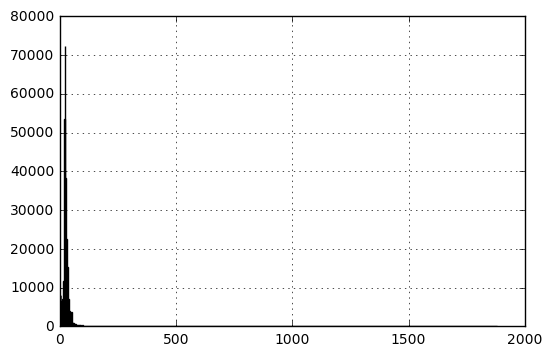

In [44]:
%matplotlib inline
segments['seg_length'].hist(bins=500)

Though most of the transits appear to be short, there are a few longer distances that make the plot difficult to read. 

This is where a transformation is useful:

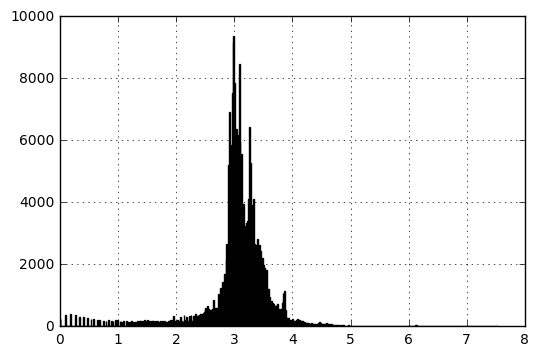

In [45]:
segments['seg_length'].apply(np.log).hist(bins=500)

We can see that although there are date/time fields in the dataset, they are not in any specialized format, such as `datetime`.

In [46]:
segments['st_time'].dtype

dtype('O')

Our first order of business will be to convert these data to `datetime`. 

The `strptime` method parses a string representation of a date and/or time field, according to the expected format of this information.

In [47]:
datetime.strptime(segments['st_time'].ix[0], '%m/%d/%y %H:%M')

datetime.datetime(2009, 2, 10, 16, 3)

As a convenience, Pandas has a `to_datetime` method that will parse and convert an entire Series of formatted strings into `datetime` objects.

In [48]:
pd.to_datetime(segments['st_time'][:10])

0   2009-02-10 16:03:00
1   2009-04-06 14:31:00
2   2009-04-06 14:36:00
3   2009-04-10 17:58:00
4   2009-04-10 17:59:00
5   2010-03-20 16:06:00
6   2010-03-20 18:05:00
7   2011-05-04 11:28:00
8   2010-06-05 11:23:00
9   2010-06-08 11:03:00
Name: st_time, dtype: datetime64[ns]

Pandas also has a custom NA value for missing datetime objects, `NaT`.

In [49]:
pd.to_datetime([None])

DatetimeIndex(['NaT'], dtype='datetime64[ns]', freq=None)

Finally, if `to_datetime()` has problems parsing any particular date/time format, you can pass the spec in using the `format=` argument.

## Merging and joining `DataFrame`s

In Pandas, we can combine tables according to the value of one or more *keys* that are used to identify rows, much like an index.

In [50]:
df1 = pd.DataFrame(dict(id=range(4), 
                        age=np.random.randint(18, 31, size=4)))
df1

,age,id
0,20,0
1,21,1
2,20,2
3,24,3


In [51]:
df2 = pd.DataFrame(dict(id=list(range(3))+list(range(3)), 
                        score=np.random.random(size=6)))
df2

,id,score
0,0,0.025323
1,1,0.336570
2,2,0.866701
3,0,0.952417
4,1,0.402052
5,2,0.195401


In [52]:
pd.merge(df1, df2)

,age,id,score
0,20,0,0.025323
1,20,0,0.952417
2,21,1,0.336570
3,21,1,0.402052
4,20,2,0.866701
5,20,2,0.195401


Notice that without any information about which column to use as a key, Pandas did the right thing and used the `id` column in both tables. Unless specified otherwise, `merge` will used any common column names as keys for merging the tables. 

Notice also that `id=3` from `df1` was omitted from the merged table. This is because, by default, `merge` performs an **inner join** on the tables, meaning that the merged table represents an intersection of the two tables.

In [53]:
pd.merge(df1, df2, how='outer')

,age,id,score
0,20,0,0.025323
1,20,0,0.952417
2,21,1,0.336570
3,21,1,0.402052
4,20,2,0.866701
5,20,2,0.195401
6,24,3,NaN


The **outer join** above yields the union of the two tables, so all rows are represented, with missing values inserted as appropriate. 

One can also perform **right** and **left** joins to include all rows of the right or left table (*i.e.* first or second argument to `merge`), but not necessarily the other.

### Back to the example

Now that we have the vessel transit information as we need it, we may want a little more information regarding the vessels themselves. 

In the `data/AIS` folder there is a second table that contains information about each of the ships that traveled the segments in the `segments` table.

In [54]:
vessels = pd.read_csv('data/AIS/vessel_information.csv', index_col='mmsi')
vessels.head(2)

,num_names,names,sov,flag,flag_type,num_loas,loa,max_loa,num_types,type
mmsi,,,,,,,,,,
1,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing
9,3,000000009/Raven/Shearwater,N,Unknown,Unknown,2,50.0/62.0,62.0,2,Pleasure/Tug


In [55]:
segments.head(2)

,mmsi,name,transit,segment,seg_length,avg_sog,min_sog,max_sog,pdgt10,st_time,end_time
0,1,Us Govt Ves,1,1,5.1,13.2,9.2,14.5,96.5,2/10/09 16:03,2/10/09 16:27
1,1,Dredge Capt Frank,1,1,13.5,18.6,10.4,20.6,100.0,4/6/09 14:31,4/6/09 15:20


We see that there is a `mmsi` value (a vessel identifier) in each table, but it is used as an index for the `vessels` table. In this case, we have to specify to join on the index for this table, and on the `mmsi` column for the other.

In [56]:
segments_merged = pd.merge(vessels, segments, left_index=True, right_on='mmsi')

In [57]:
segments_merged.head()

,num_names,names,sov,flag,flag_type,num_loas,loa,max_loa,num_types,type,...,name,transit,segment,seg_length,avg_sog,min_sog,max_sog,pdgt10,st_time,end_time
0,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Us Govt Ves,1,1,5.1,13.2,9.2,14.5,96.5,2/10/09 16:03,2/10/09 16:27
1,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Dredge Capt Frank,1,1,13.5,18.6,10.4,20.6,100.0,4/6/09 14:31,4/6/09 15:20
2,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Us Gov Vessel,1,1,4.3,16.2,10.3,20.5,100.0,4/6/09 14:36,4/6/09 14:55
3,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Us Gov Vessel,2,1,9.2,15.4,14.5,16.1,100.0,4/10/09 17:58,4/10/09 18:34
4,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Dredge Capt Frank,2,1,9.2,15.4,14.6,16.2,100.0,4/10/09 17:59,4/10/09 18:35


Notice that `mmsi` field that was an index on the `vessels` table is no longer an index on the merged table.

Each `DataFrame` also has a `.merge()` method that could have been used:

In [58]:
vessels.merge(segments, left_index=True, right_on='mmsi').head()

,num_names,names,sov,flag,flag_type,num_loas,loa,max_loa,num_types,type,...,name,transit,segment,seg_length,avg_sog,min_sog,max_sog,pdgt10,st_time,end_time
0,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Us Govt Ves,1,1,5.1,13.2,9.2,14.5,96.5,2/10/09 16:03,2/10/09 16:27
1,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Dredge Capt Frank,1,1,13.5,18.6,10.4,20.6,100.0,4/6/09 14:31,4/6/09 15:20
2,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Us Gov Vessel,1,1,4.3,16.2,10.3,20.5,100.0,4/6/09 14:36,4/6/09 14:55
3,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Us Gov Vessel,2,1,9.2,15.4,14.5,16.1,100.0,4/10/09 17:58,4/10/09 18:34
4,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,Dredge Capt Frank,2,1,9.2,15.4,14.6,16.2,100.0,4/10/09 17:59,4/10/09 18:35


Occasionally, there will be fields with the same in both tables that we do not wish to use to join the tables; they may contain different information, despite having the same name. 

In this case, Pandas will by default append suffixes `_x` and `_y` to the columns to uniquely identify them.

In [59]:
segments['type'] = 'foo'
pd.merge(vessels, segments, left_index=True, right_on='mmsi').head()

,num_names,names,sov,flag,flag_type,num_loas,loa,max_loa,num_types,type_x,...,transit,segment,seg_length,avg_sog,min_sog,max_sog,pdgt10,st_time,end_time,type_y
0,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,1,1,5.1,13.2,9.2,14.5,96.5,2/10/09 16:03,2/10/09 16:27,foo
1,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,1,1,13.5,18.6,10.4,20.6,100.0,4/6/09 14:31,4/6/09 15:20,foo
2,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,1,1,4.3,16.2,10.3,20.5,100.0,4/6/09 14:36,4/6/09 14:55,foo
3,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,2,1,9.2,15.4,14.5,16.1,100.0,4/10/09 17:58,4/10/09 18:34,foo
4,8,Bil Holman Dredge/Dredge Capt Frank/Emo/Offsho...,Y,Unknown,Unknown,7,42.0/48.0/57.0/90.0/138.0/154.0/156.0,156.0,4,Dredging/MilOps/Reserved/Towing,...,2,1,9.2,15.4,14.6,16.2,100.0,4/10/09 17:59,4/10/09 18:35,foo


This behavior can be overridden by specifying a `suffixes` argument, containing a list of the suffixes to be used for the columns of the left and right columns, respectively.

## Reshaping `DataFrame`s

This dataset in from Table 6.9 of [Statistical Methods for the Analysis of Repeated Measurements](http://www.amazon.com/Statistical-Methods-Analysis-Repeated-Measurements/dp/0387953701) by Charles S. Davis, pp. 161-163 (Springer, 2002). These data are from a multicenter, randomized controlled trial of botulinum toxin type B (BotB) in patients with cervical dystonia from nine U.S. sites.

* Randomized to placebo (N=36), 5000 units of BotB (N=36), 10,000 units of BotB (N=37)
* Response variable: total score on Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment)
* TWSTRS measured at baseline (week 0) and weeks 2, 4, 8, 12, 16 after treatment began

In [60]:
cdystonia = pd.read_csv('data/cdystonia.csv', index_col=None)
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


This dataset includes repeated measurements of the same individuals (longitudinal data). Its possible to present such information in (at least) two ways: showing each repeated measurement in their own row, or in multiple columns representing multiple measurements.

`.stack()` rotates the data frame so that columns are represented in rows:

In [61]:
stacked = cdystonia.stack()
stacked

0    patient        1
     obs            1
     week           0
     site           1
     id             1
                ...  
630  id            11
     treat      5000U
     age           57
     sex            M
     twstrs        51
dtype: object

And there's a corresponding `.unstack()` which pivots back into columns:

In [62]:
stacked.unstack().head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


For this dataset, it makes sense to create a hierarchical index based on the patient and observation:

In [63]:
cdystonia2 = cdystonia.set_index(['patient','obs'])
cdystonia2.head()

week  site  id  treat  age sex  twstrs
patient obs                                        
1       1       0     1   1  5000U   65   F      32
        2       2     1   1  5000U   65   F      30
        3       4     1   1  5000U   65   F      24
        4       8     1   1  5000U   65   F      37
        5      12     1   1  5000U   65   F      39

In [64]:
print(cdystonia2.index.levels[0])
print(cdystonia2.index.levels[1])

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
           dtype='int64', name='patient', length=109)
Int64Index([1, 2, 3, 4, 5, 6], dtype='int64', name='obs')


In [65]:
cdystonia2.index.labels

FrozenList([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, ...], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, ...]])

In [66]:
cdystonia2.index.values[0:5]

array([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)], dtype=object)

In [67]:
cdystonia2.index.get_level_values('obs')

Int64Index([1, 2, 3, 4, 5, 6, 1, 2, 3, 4,
            ...
            2, 3, 4, 5, 6, 1, 2, 4, 5, 6],
           dtype='int64', name='obs', length=631)

In [68]:
cdystonia2.index.is_unique

True

If we want to transform this data so that repeated measurements are in columns, we can `unstack` the `twstrs` measurements according to `obs`:

In [69]:
cdystonia2.head()

week  site  id  treat  age sex  twstrs
patient obs                                        
1       1       0     1   1  5000U   65   F      32
        2       2     1   1  5000U   65   F      30
        3       4     1   1  5000U   65   F      24
        4       8     1   1  5000U   65   F      37
        5      12     1   1  5000U   65   F      39

In [70]:
twstrs_wide = cdystonia2['twstrs'].unstack('obs')
twstrs_wide.head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


And if we want to keep the other variables:

In [71]:
cdystonia_wide = (cdystonia[['patient','site','id','treat','age','sex']]
                  .drop_duplicates()
                  .merge(twstrs_wide, right_index=True, left_on='patient', how='inner')
                  .head())
cdystonia_wide

,patient,site,id,treat,age,sex,1,2,3,4,5,6
0,1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
6,2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
12,3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
18,4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
22,5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


Or to simplify things, we can set the patient-level information as an index before unstacking:

In [72]:
(cdystonia.set_index(['patient','site','id','treat','age','sex','week'])['twstrs']
     .unstack('week').head())

,,,,,week,0,2,4,8,12,16
patient,site,id,treat,age,sex,,,,,,
1,1,1,5000U,65,F,32.0,30.0,24.0,37.0,39.0,36.0
2,1,2,10000U,70,F,60.0,26.0,27.0,41.0,65.0,67.0
3,1,3,5000U,64,F,44.0,20.0,23.0,26.0,35.0,35.0
4,1,4,Placebo,59,F,53.0,61.0,64.0,62.0,NaN,NaN
5,1,5,10000U,76,F,53.0,35.0,48.0,49.0,41.0,51.0


### [`.melt()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html)

- To convert our "wide" format back to long, we can use the `melt` function. 
- This function is useful for `DataFrame`s where one or more columns are identifier variables (`id_vars`), with the remaining columns being measured variables (`value_vars`). 
- The measured variables are "unpivoted" to the row axis, leaving just two non-identifier columns, a *variable* and its corresponding *value*, which can both be renamed using optional arguments.

In [73]:
pd.melt(cdystonia_wide, id_vars=['patient','site','id','treat','age','sex'], 
        var_name='obs', value_name='twsters').head()

,patient,site,id,treat,age,sex,obs,twsters
0,1,1,1,5000U,65,F,1,32.0
1,2,1,2,10000U,70,F,1,60.0
2,3,1,3,5000U,64,F,1,44.0
3,4,1,4,Placebo,59,F,1,53.0
4,5,1,5,10000U,76,F,1,53.0


## Pivoting

The `pivot` method allows a DataFrame to be transformed easily between long and wide formats in the same way as a pivot table is created in a spreadsheet. 

It takes three arguments: `index`, `columns` and `values`, corresponding to the DataFrame index (the row headers), columns and cell values, respectively.

For example, we may want the `twstrs` variable (the response variable) in wide format according to patient, as we saw with the unstacking method above:

In [74]:
cdystonia.pivot(index='patient', columns='obs', values='twstrs').head()

obs,1,2,3,4,5,6
patient,,,,,,
1,32.0,30.0,24.0,37.0,39.0,36.0
2,60.0,26.0,27.0,41.0,65.0,67.0
3,44.0,20.0,23.0,26.0,35.0,35.0
4,53.0,61.0,64.0,62.0,NaN,NaN
5,53.0,35.0,48.0,49.0,41.0,51.0


If we omit the `values` argument, we get a `DataFrame` with hierarchical columns, just as when we applied `unstack` to the hierarchically-indexed table:

In [75]:
cdystonia.pivot('patient', 'obs')

week                            site                 ...    sex     \
obs        1    2    3    4     5     6    1    2    3    4  ...      3  4   
patient                                                      ...             
1        0.0  2.0  4.0  8.0  12.0  16.0  1.0  1.0  1.0  1.0  ...      F  F   
2        0.0  2.0  4.0  8.0  12.0  16.0  1.0  1.0  1.0  1.0  ...      F  F   
3        0.0  2.0  4.0  8.0  12.0  16.0  1.0  1.0  1.0  1.0  ...      F  F   
4        0.0  2.0  4.0  8.0   NaN   NaN  1.0  1.0  1.0  1.0  ...      F  F   
5        0.0  2.0  4.0  8.0  12.0  16.0  1.0  1.0  1.0  1.0  ...      F  F   
...      ...  ...  ...  ...   ...   ...  ...  ...  ...  ...  ...    ... ..   
105      0.0  2.0  4.0  8.0  12.0  16.0  9.0  9.0  9.0  9.0  ...      F  F   
106      0.0  2.0  4.0  8.0  12.0  16.0  9.0  9.0  9.0  9.0  ...      M  M   
107      0.0  NaN  4.0  8.0   NaN  16.0  9.0  NaN  9.0  9.0  ...      M  M   
108      0.0  2.0  4.0  8.0  12.0  16.0  9.0  9.0  9.0  9.0  ...      F  F   
109      0.0  2.0  NaN  8.0  12.0  16.0  9.0  9.0  NaN  9.0  ...   None  M   

                    twstrs                                
obs         5     6      1     2     3     4     5     6  
patient                                                   
1           F     F   32.0  30.0  24.0  37.0  39.0  36.0  
2           F     F   60.0  26.0  27.0  41.0  65.0  67.0  
3           F     F   44.0  20.0  23.0  26.0  35.0  35.0  
4        None  None   53.0  61.0  64.0  62.0   NaN   NaN  
5           F     F   53.0  35.0  48.0  49.0  41.0  51.0  
...       ...   ...    ...   ...   ...   ...   ...   ...  
105         F     F   45.0  46.0  33.0  44.0  46.0  48.0  
106         M     M   67.0  63.0  71.0  66.0  68.0  71.0  
107      None     M   57.0   NaN  36.0  23.0   NaN  52.0  
108         F     F   63.0  51.0  46.0  50.0  50.0  54.0  
109         M     M   53.0  38.0   NaN  33.0  36.0  51.0  

[109 rows x 42 columns]

A related method, `pivot_table`, creates a spreadsheet-like table with a hierarchical index, and allows the values of the table to be populated using an arbitrary aggregation function.

In [76]:
cdystonia.head()

,patient,obs,week,site,id,treat,age,sex,twstrs
0,1,1,0,1,1,5000U,65,F,32
1,1,2,2,1,1,5000U,65,F,30
2,1,3,4,1,1,5000U,65,F,24
3,1,4,8,1,1,5000U,65,F,37
4,1,5,12,1,1,5000U,65,F,39


In [77]:
cdystonia.pivot_table(index=['site', 'treat'], columns='week', values='twstrs', 
                      aggfunc=max).head(20)

week          0   2   4   8   12  16
site treat                          
1    10000U   60  41  48  49  65  67
     5000U    44  32  34  43  42  46
     Placebo  53  61  64  62  32  38
2    10000U   65  60  60  64  67  66
     5000U    67  64  65  64  62  64
...           ..  ..  ..  ..  ..  ..
6    10000U   55  56  47  53  51  51
     5000U    59  55  50  56  59  53
     Placebo  54  53  51  57  57  57
7    10000U   53  47  45  45  50  53
     5000U    53  45  52  51  52  53

[20 rows x 6 columns]

## Crosstabs and Summaries

For a simple cross-tabulation of group frequencies, the `crosstab` function (not a method) aggregates counts of data according to factors in rows and columns. The factors may be hierarchical if desired.

In [78]:
pd.crosstab(cdystonia['sex'], cdystonia['site'])

site,1,2,3,4,5,6,7,8,9
sex,,,,,,,,,
F,52,53,42,30,22,54,66,48,28
M,18,29,30,18,11,33,6,58,33


And the `.describe()` method gives some useful summary information on the `DataFrame`:

In [79]:
cdystonia.describe()

,patient,obs,week,site,id,age,twstrs
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,54.402536,3.484945,6.957211,5.118859,7.020602,55.616482,41.478605
std,31.308495,1.716219,5.645316,2.669667,4.285215,12.123910,12.716784
min,1.000000,1.000000,0.000000,1.000000,1.000000,26.000000,6.000000
25%,27.500000,2.000000,2.000000,3.000000,3.000000,46.000000,32.500000
50%,54.000000,3.000000,4.000000,6.000000,7.000000,56.000000,43.000000
75%,81.000000,5.000000,12.000000,8.000000,10.000000,65.000000,51.000000
max,109.000000,6.000000,16.000000,9.000000,19.000000,83.000000,71.000000


## Exercise 4

Open up [Lecture 4/Exercise 4.ipynb](./Exercise 4.ipynb) in your Jupyter notebook server.

Solutions are at [Lecture 4/Exercise 4 - Solutions.ipynb](./Exercise 4 - Solutions.ipynb)

## References

Slide materials inspired by and adapted from [Chris Fonnesbeck](https://github.com/fonnesbeck/statistical-analysis-python-tutorial) and [Tom Augspurger](https://github.com/TomAugspurger/pydata-chi-h2t)